In [30]:
# SAR to EO Image Translation using CycleGAN
# Project 1: Summer School on Deep Dive in Deep Learning

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from PIL import Image
import itertools
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import cv2
!pip install rasterio
import rasterio
import warnings
from torch.optim import lr_scheduler
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [31]:
# ===== DATA PREPROCESSING =====

class SARToEODataset(Dataset):
    """
    Dataset class for SAR to EO image pairs
    Handles normalization to [-1, 1] as required by GAN architectures
    """
    def __init__(self, sar_dir, eo_dir, transform=None, band_config='rgb'):
        self.sar_dir = sar_dir
        self.eo_dir = eo_dir
        self.transform = transform
        self.band_config = band_config
        
        # Get all SAR files
        self.sar_files = sorted(glob.glob(os.path.join(sar_dir,'**', "*.tif"),recursive=True))
        self.eo_files = sorted(glob.glob(os.path.join(eo_dir,'**', "*.tif"),recursive=True))

        print(f"SARToEODataset: Initializing with sar_dir='{sar_dir}' and eo_dir='{eo_dir}'")
        print(f"SARToEODataset: Found {len(self.sar_files)} SAR files recursively.")
        print(f"SARToEODataset: Found {len(self.eo_files)} EO files recursively.")
        
        # Ensure matching pairs
        assert len(self.sar_files) == len(self.eo_files), "Mismatch in SAR and EO file counts"

        self.paired_files = list(zip(self.sar_files, self.eo_files))
        print(f"SARToEODataset: Created {len(self.paired_files)} paired files.")
        
    def __len__(self):
        return len(self.paired_files)

    def __getitem__(self, idx):
        sar_path, eo_path = self.paired_files[idx]
        
        # --- MODIFIED: Use rasterio for loading images ---
        sar_img = self.load_image_with_rasterio(sar_path)
        eo_img = self.load_eo_image_with_rasterio(eo_path, self.band_config)
        # --------------------------------------------------
        
        sar_img = self.normalize_image(sar_img)
        eo_img = self.normalize_image(eo_img)
        
        if self.transform:
            sar_img = self.transform(sar_img)
            eo_img = self.transform(eo_img)
            
        return sar_img, eo_img


    def load_image_with_rasterio(self, path):
        with rasterio.open(path) as src:
            img = src.read().astype(np.float32) # Read all bands and convert to float32
        
        # rasterio reads as (C, H, W) by default, which is what PyTorch expects.
        # No need for transpose unless it's a specific single-channel case,
        # but SAR is usually 2-channel, and EO is multi-channel.
        return torch.from_numpy(img)
    
    # --- MODIFIED: EO IMAGE LOADING WITH RASTERIO AND BAND SELECTION ---
    def load_eo_image_with_rasterio(self, path, band_config):
        with rasterio.open(path) as src:
            # Read all bands first. Rasterio reads as (num_bands, height, width).
            full_img_bands = src.read().astype(np.float32) 
        
        img = None # Initialize img to None
        
        if band_config == 'rgb':
            # Assuming bands B2, B3, B4 are typically at indices 0, 1, 2 or similar
            # for stacked Sentinel-2 TIFFs (Blue, Green, Red).
            # For visualization/common RGB, it's often [R, G, B] which means [B4, B3, B2]
            # If `full_img_bands` is (B2, B3, B4, ...) then indices [2,1,0] is for B4,B3,B2
            # If you want just the first three bands as they are:
            if full_img_bands.shape[0] >= 3:
                img = full_img_bands[[2, 1, 0], :, :] # Common: B4 (Red), B3 (Green), B2 (Blue)
            else:
                print(f"Warning: Not enough bands for RGB in {path}. Found {full_img_bands.shape[0]} bands. Using all available.")
                img = full_img_bands
        elif band_config == 'nir_swir_red_edge':
            # B8 (NIR), B11 (SWIR), B5 (Red Edge)
            # Based on common S2 band order (B2, B3, B4, B5, B6, B7, B8, B8A, B11, B12), approximate indices:
            # B8: index 6
            # B11: index 8
            # B5: index 3
            if full_img_bands.shape[0] >= 9: # Need at least 9 bands for B11
                img = full_img_bands[[6, 8, 3], :, :] # B8, B11, B5 approximately
            else:
                print(f"Warning: Not enough bands for {band_config} in {path}. Found {full_img_bands.shape[0]} bands. Falling back to RGB (B4,B3,B2).")
                if full_img_bands.shape[0] >= 3:
                    img = full_img_bands[[2, 1, 0], :, :]
                else:
                    img = full_img_bands # Fallback to whatever is available
        elif band_config == 'rgb_nir':
            # B4, B3, B2, B8 (RGB + NIR)
            # Indices: B4(2), B3(1), B2(0), B8(6)
            if full_img_bands.shape[0] >= 7: # Need at least 7 bands for B8
                img = full_img_bands[[2, 1, 0, 6], :, :] # B4, B3, B2, B8
            else:
                print(f"Warning: Not enough bands for {band_config} in {path}. Found {full_img_bands.shape[0]} bands. Falling back to RGB (B4,B3,B2).")
                if full_img_bands.shape[0] >= 3:
                    img = full_img_bands[[2, 1, 0], :, :]
                else:
                    img = full_img_bands # Fallback to whatever is available
        else: # Default case if band_config is unknown or not supported explicitly
            print(f"Warning: Unknown band_config '{band_config}'. Using first 3 bands as default.")
            if full_img_bands.shape[0] >= 3:
                img = full_img_bands[:3, :, :] # Take first 3 bands
            else:
                img = full_img_bands # Use whatever available bands

        if img is None: # Fallback if no specific selection was made or not enough bands
            img = full_img_bands[:3] if full_img_bands.shape[0] >=3 else full_img_bands

        return torch.from_numpy(img)
  
  
    def normalize_image(self, img):
        img_min = torch.min(img)
        img_max = torch.max(img)
        if img_max > img_min:
            img = (img - img_min) / (img_max - img_min)
        else:
            img = torch.zeros_like(img) 
        img = img * 2.0 - 1.0
        return img


# Data transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    # transforms.RandomHorizontalFlip(p=0.5),
])

In [32]:
# ===== CYCLEGAN MODEL ARCHITECTURE =====

class ResidualBlock(nn.Module):
    """Residual block for generator"""
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features)
        )
    
    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    """CycleGAN Generator"""
    def __init__(self, input_nc, output_nc, n_residual_blocks=9):
        super(Generator, self).__init__()
        
        # Initial convolution block
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(input_nc, 64, 7),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        ]
        
        # Downsampling
        in_features = 64
        out_features = in_features * 2
        for _ in range(2):
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features = in_features * 2
        
        # Residual blocks
        for _ in range(n_residual_blocks):
            model += [ResidualBlock(in_features)]
        
        # Upsampling
        out_features = in_features // 2
        for _ in range(2):
            model += [
                nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features = in_features // 2
        
        # Output layer
        model += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(64, output_nc, 7),
            nn.Tanh()
        ]
        
        self.model = nn.Sequential(*model)
    
    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    """CycleGAN Discriminator (PatchGAN)"""
    def __init__(self, input_nc):
        super(Discriminator, self).__init__()
        
        # A bunch of convolutions one after another
        model = [
            nn.Conv2d(input_nc, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        ]
        
        model += [
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        ]
        
        model += [
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        ]
        
        model += [
            nn.Conv2d(256, 512, 4, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        ]
        
        # FCN classification layer
        model += [nn.Conv2d(512, 1, 4, padding=1)]
        
        self.model = nn.Sequential(*model)
    
    def forward(self, x):
        x = self.model(x)
        # Average pooling and flatten
        return torch.mean(x, dim=[2, 3])

In [33]:
def train_cyclegan_config(sar_dir, eo_dir, band_config, num_epochs=25, batch_size=4):
    # ... (existing code)

    # Generate sample results
    output_dir = f'/kaggle/working/generated_samples/{band_config}/' # <-- MODIFIED PATH
    print("\nGenerating sample results...")
    visualize_results(trainer, dataloader, num_samples=5,
                     save_path=output_dir) # Use the modified output_dir

    # Plot training losses - no change needed for plotting, it uses in-memory history

    # Save final model
    final_model_path = f'/kaggle/working/final_model_{band_config}.pth' # <-- MODIFIED PATH
    trainer.save_models(final_model_path) # Pass the full path

    return trainer, metrics

In [34]:
# ===== TRAINING CONFIGURATION =====

class CycleGANTrainer:
    """CycleGAN training class"""
    def __init__(self, sar_channels=2, eo_channels=3, lr=0.0002, beta1=0.5, lambda_cyc=10.0, lambda_id=0.5,num_epochs = 50):
        # Initialize generators and discriminators
        self.G_SAR2EO = Generator(sar_channels, eo_channels).to(device)
        self.G_EO2SAR = Generator(eo_channels, sar_channels).to(device)
        self.D_SAR = Discriminator(sar_channels).to(device)
        self.D_EO = Discriminator(eo_channels).to(device)

        self.G_SAR_ID = Generator(sar_channels, sar_channels).to(device)
        self.G_EO_ID = Generator(sar_channels, eo_channels).to(device)
        
        # Loss functions
        self.criterion_GAN = nn.MSELoss()
        self.criterion_cycle = nn.L1Loss()
        self.criterion_identity = nn.L1Loss()
        
        # Optimizers
        self.optimizer_G = optim.Adam(
            itertools.chain(itertools.chain(self.G_SAR2EO.parameters(), self.G_EO2SAR.parameters(), self.G_SAR_ID.parameters(), self.G_EO_ID.parameters())),
            lr=lr, betas=(beta1, 0.999)
        )
        self.optimizer_D_SAR = optim.Adam(self.D_SAR.parameters(), lr=lr, betas=(beta1, 0.999))
        self.optimizer_D_EO = optim.Adam(self.D_EO.parameters(), lr=lr, betas=(beta1, 0.999))

        # def lambda_rule(epoch):
        #     # Start linear decay after a certain number of epochs, e.g., half of total epochs
        #     n_epochs_decay = num_epochs // 2 # or fixed value like 100
        #     if epoch < n_epochs_decay:
        #         return 1.0
        #     return 1.0 - max(0, epoch - n_epochs_decay) / float(n_epochs_decay)
            
        # self.scheduler_G = lr_scheduler.LambdaLR(self.optimizer_G, lr_lambda=lambda_rule)
        # self.scheduler_D_SAR = lr_scheduler.LambdaLR(self.optimizer_D_SAR, lr_lambda=lambda_rule)
        # self.scheduler_D_EO = lr_scheduler.LambdaLR(self.optimizer_D_EO, lr_lambda=lambda_rule)
        
        # Loss weights
        self.lambda_cyc = lambda_cyc
        self.lambda_id = lambda_id
        
        # Loss history
        self.loss_history = {
            'G_loss': [],
            'D_SAR_loss': [],
            'D_EO_loss': [],
            'cycle_loss': [],
            # 'identity_loss': []
        }
        
        def save_models(self, checkpoint_path): # Changed checkpoint_name to checkpoint_path
            """Save model checkpoints"""
            os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True) # Ensure directory exists
            torch.save({
            'G_SAR2EO': self.G_SAR2EO.state_dict(),
            'G_EO2SAR': self.G_EO2SAR.state_dict(),
            'D_SAR': self.D_SAR.state_dict(),
            'D_EO': self.D_EO.state_dict(),
            }, checkpoint_path) # Use the full path
            print(f"Models saved as {checkpoint_path}")
    
    def train_step(self, sar_real, eo_real):
        """Single training step"""

        batch_size = sar_real.size(0)
        
        # Real and fake labels
        real_label = torch.ones(batch_size, 1).to(device)
        fake_label = torch.zeros(batch_size, 1).to(device)

        
        # ===== Train Generators =====
        self.optimizer_G.zero_grad()
        
        # Identity loss
        # identity_sar = self.G_EO2SAR(sar_real)  
        # identity_eo = self.G_SAR2EO(eo_real) 
        # loss_identity = (self.criterion_identity(identity_eo, eo_real) + 
        #                 self.criterion_identity(identity_sar, sar_real)) * self.lambda_id
        
        # identity_eo_output = self.G_EO_ID(eo_real)
        # identity_sar_output = self.G_SAR_ID(sar_real)
        # loss_identity = (self.criterion_identity(identity_eo_output, eo_real) + self.criterion_identity(identity_sar_output, sar_real)) * self.lambda_id
        
        # GAN loss
        fake_eo = self.G_SAR2EO(sar_real)
        fake_sar = self.G_EO2SAR(eo_real)
        
        loss_GAN_SAR2EO = self.criterion_GAN(self.D_EO(fake_eo), real_label)
        loss_GAN_EO2SAR = self.criterion_GAN(self.D_SAR(fake_sar), real_label)
        loss_GAN = loss_GAN_SAR2EO + loss_GAN_EO2SAR
        
        # Cycle loss
        recovered_sar = self.G_EO2SAR(fake_eo)
        recovered_eo = self.G_SAR2EO(fake_sar)
        loss_cycle = (self.criterion_cycle(recovered_sar, sar_real) + 
                     self.criterion_cycle(recovered_eo, eo_real)) * self.lambda_cyc
        
        # Total generator loss
        loss_G = loss_GAN + loss_cycle
        # loss_G = loss_GAN + loss_cycle + loss_identity
        loss_G.backward()
        
        # self.scheduler_G.step()
        # self.scheduler_D_SAR.step()
        # self.scheduler_D_EO.step() 
        self.optimizer_G.step()
        

        # ===== Train Discriminator SAR =====
        self.optimizer_D_SAR.zero_grad()
        
        # Real loss
        pred_real = self.D_SAR(sar_real)
        loss_D_real = self.criterion_GAN(pred_real, real_label)
        
        # Fake loss
        pred_fake = self.D_SAR(fake_sar.detach())
        loss_D_fake = self.criterion_GAN(pred_fake, fake_label)
        
        # Total discriminator loss
        loss_D_SAR = (loss_D_real + loss_D_fake) * 0.5
        loss_D_SAR.backward()
        self.optimizer_D_SAR.step()
        
        # ===== Train Discriminator EO =====
        self.optimizer_D_EO.zero_grad()
        
        # Real loss
        pred_real = self.D_EO(eo_real)
        loss_D_real = self.criterion_GAN(pred_real, real_label)
        
        # Fake loss  
        pred_fake = self.D_EO(fake_eo.detach())
        loss_D_fake = self.criterion_GAN(pred_fake, fake_label)
        
        # Total discriminator loss
        loss_D_EO = (loss_D_real + loss_D_fake) * 0.5
        loss_D_EO.backward()
        self.optimizer_D_EO.step()
        
        # Store losses
        self.loss_history['G_loss'].append(loss_G.item())
        self.loss_history['D_SAR_loss'].append(loss_D_SAR.item())
        self.loss_history['D_EO_loss'].append(loss_D_EO.item())
        self.loss_history['cycle_loss'].append(loss_cycle.item())
        # self.loss_history['identity_loss'].append(loss_identity.item())
        
        return {
            'G_loss': loss_G.item(),
            'D_SAR_loss': loss_D_SAR.item(),
            'D_EO_loss': loss_D_EO.item(),
            'cycle_loss': loss_cycle.item(),
            # 'identity_loss': loss_identity.item()
        }
    
    def train(self, dataloader, num_epochs=100):
        """Train the CycleGAN model"""
        print(f"Starting training for {num_epochs} epochs...")
        
        for epoch in range(num_epochs):
            # epoch_losses = {'G_loss': 0, 'D_SAR_loss': 0, 'D_EO_loss': 0, 'cycle_loss': 0, 'identity_loss': 0}
            epoch_losses = {'G_loss': 0, 'D_SAR_loss': 0, 'D_EO_loss': 0, 'cycle_loss': 0}
            
            for i, (sar_imgs, eo_imgs) in enumerate(dataloader):
                sar_imgs = sar_imgs.to(device)
                eo_imgs = eo_imgs.to(device)
                
                losses = self.train_step(sar_imgs, eo_imgs)
                
                # Accumulate losses
                for key in epoch_losses:
                    epoch_losses[key] += losses[key]
                
                # Print progress
                if i % 50 == 0:
                    print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], "
                          f"G_loss: {losses['G_loss']:.4f}, D_loss: {(losses['D_SAR_loss'] + losses['D_EO_loss'])/2:.4f}")
            
            # Average losses for the epoch
            for key in epoch_losses:
                epoch_losses[key] /= len(dataloader)
            
            print(f"Epoch [{epoch+1}/{num_epochs}] - Average Losses: "
                  f"G: {epoch_losses['G_loss']:.4f}, "
                  f"D_SAR: {epoch_losses['D_SAR_loss']:.4f}, "
                  f"D_EO: {epoch_losses['D_EO_loss']:.4f}, "
                  f"Cycle: {epoch_losses['cycle_loss']:.4f}")
            
            # Save model checkpoints every 10 epochs
            if (epoch + 1) % 10 == 0:
                checkpoint_dir = '/kaggle/working/checkpoints/' # <-- NEW: define checkpoint directory
                os.makedirs(checkpoint_dir, exist_ok=True) # Ensure it exists
                self.save_models(f'checkpoint_epoch_{epoch+1}')
                self.save_models(os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch+1}.pth'))
    
    def save_models(self, checkpoint_name):
        """Save model checkpoints"""
        torch.save({
            'G_SAR2EO': self.G_SAR2EO.state_dict(),
            'G_EO2SAR': self.G_EO2SAR.state_dict(),
            'D_SAR': self.D_SAR.state_dict(),
            'D_EO': self.D_EO.state_dict(),
        }, f'{checkpoint_name}.pth')
        print(f"Models saved as {checkpoint_name}.pth")   

In [35]:
# ===== EVALUATION METRICS =====

def denormalize_image(img):
    """Convert image from [-1, 1] to [0, 1] range"""
    return (img + 1) / 2

def calculate_ssim(img1, img2):
    """Calculate SSIM between two images"""
    # Convert to numpy and ensure proper shape
    if torch.is_tensor(img1):
        img1 = img1.detach().cpu().numpy()
    if torch.is_tensor(img2):
        img2 = img2.detach().cpu().numpy()
    
    # Ensure images are in [0, 1] range
    img1 = np.clip(img1, 0, 1)
    img2 = np.clip(img2, 0, 1)
    
    # Calculate SSIM for each channel and average
    if len(img1.shape) == 3:
        ssim_values = []
        for i in range(img1.shape[0]):
            ssim_val = ssim(img1[i], img2[i], data_range=1.0)
            ssim_values.append(ssim_val)
        return np.mean(ssim_values)
    else:
        return ssim(img1, img2, data_range=1.0)

def calculate_psnr(img1, img2):
    """Calculate PSNR between two images"""
    if torch.is_tensor(img1):
        img1 = img1.detach().cpu().numpy()
    if torch.is_tensor(img2):
        img2 = img2.detach().cpu().numpy()
    
    # Ensure images are in [0, 1] range
    img1 = np.clip(img1, 0, 1)
    img2 = np.clip(img2, 0, 1)
    
    return psnr(img1, img2, data_range=1.0)

def calculate_ndvi(nir_band, red_band):
    """Calculate NDVI from NIR and Red bands"""
    # Avoid division by zero
    denominator = nir_band + red_band
    denominator = np.where(denominator == 0, 1e-8, denominator)
    
    ndvi = (nir_band - red_band) / denominator
    return ndvi

def evaluate_model(trainer, test_dataloader, num_samples=5):
    """Evaluate the trained model"""
    trainer.G_SAR2EO.eval()
    
    ssim_scores = []
    psnr_scores = []
    
    with torch.no_grad():
        for i, (sar_imgs, eo_real) in enumerate(test_dataloader):
            if i >= num_samples:
                break
                
            sar_imgs = sar_imgs.to(device)
            eo_real = eo_real.to(device)
            
            # Generate fake EO images
            eo_fake = trainer.G_SAR2EO(sar_imgs)
            
            # Calculate metrics for each image in batch
            for j in range(sar_imgs.size(0)):
                real_img = denormalize_image(eo_real[j])
                fake_img = denormalize_image(eo_fake[j])
                
                ssim_score = calculate_ssim(real_img, fake_img)
                psnr_score = calculate_psnr(real_img, fake_img)
                
                ssim_scores.append(ssim_score)
                psnr_scores.append(psnr_score)
    
    return {
        'avg_ssim': np.mean(ssim_scores),
        'avg_psnr': np.mean(psnr_scores),
        'ssim_std': np.std(ssim_scores),
        'psnr_std': np.std(psnr_scores)
    }

In [36]:
# ===== VISUALIZATION FUNCTIONS =====

def visualize_results(trainer, test_dataloader, num_samples=5, save_path='generated_samples/'):
    """Visualize SAR to EO translation results"""
    os.makedirs(save_path, exist_ok=True)
    
    trainer.G_SAR2EO.eval()
    
    with torch.no_grad():
        for i, (sar_imgs, eo_real) in enumerate(test_dataloader):
            if i >= num_samples:
                break
                
            sar_imgs = sar_imgs.to(device)
            eo_real = eo_real.to(device)
            
            # Generate fake EO images
            eo_fake = trainer.G_SAR2EO(sar_imgs)
            
            # Process first image in batch
            sar_img = denormalize_image(sar_imgs[0]).cpu().numpy()
            real_eo = denormalize_image(eo_real[0]).cpu().numpy()
            fake_eo = denormalize_image(eo_fake[0]).cpu().numpy()
            
            # Create visualization
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            
            # SAR image (show first channel or composite)
            if sar_img.shape[0] == 2:
                # For 2-channel SAR, create RGB composite
                sar_display = np.zeros((sar_img.shape[1], sar_img.shape[2], 3))
                sar_display[:, :, 0] = sar_img[0]  # VV to Red
                sar_display[:, :, 1] = sar_img[1]  # VH to Green
                sar_display[:, :, 2] = (sar_img[0] + sar_img[1]) / 2  # Composite to Blue
            else:
                sar_display = np.transpose(sar_img, (1, 2, 0))
            
            axes[0].imshow(np.clip(sar_display, 0, 1))
            axes[0].set_title('SAR Input')
            axes[0].axis('off')
            
            # Real EO image
            if real_eo.shape[0] >= 3:
                real_display = np.transpose(real_eo[:3], (1, 2, 0))
            else:
                real_display = np.transpose(real_eo, (1, 2, 0))
            
            axes[1].imshow(np.clip(real_display, 0, 1))
            axes[1].set_title('Real EO')
            axes[1].axis('off')
            
            # Generated EO image
            if fake_eo.shape[0] >= 3:
                fake_display = np.transpose(fake_eo[:3], (1, 2, 0))
            else:
                fake_display = np.transpose(fake_eo, (1, 2, 0))
            
            axes[2].imshow(np.clip(fake_display, 0, 1))
            axes[2].set_title('Generated EO')
            axes[2].axis('off')
            
            plt.tight_layout()
            plt.savefig(f'{save_path}/sample_{i+1}.png', dpi=300, bbox_inches='tight')
            plt.show()

def plot_training_losses(trainer):
    """Plot training loss curves"""
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Generator loss
    axes[0, 0].plot(trainer.loss_history['G_loss'])
    axes[0, 0].set_title('Generator Loss')
    axes[0, 0].set_xlabel('Iteration')
    axes[0, 0].set_ylabel('Loss')
    
    # Discriminator losses
    axes[0, 1].plot(trainer.loss_history['D_SAR_loss'], label='D_SAR')
    axes[0, 1].plot(trainer.loss_history['D_EO_loss'], label='D_EO')
    axes[0, 1].set_title('Discriminator Losses')
    axes[0, 1].set_xlabel('Iteration')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    
    # Cycle loss
    axes[1, 0].plot(trainer.loss_history['cycle_loss'])
    axes[1, 0].set_title('Cycle Consistency Loss')
    axes[1, 0].set_xlabel('Iteration')
    axes[1, 0].set_ylabel('Loss')
    
    # # Identity loss
    # axes[1, 1].plot(trainer.loss_history['identity_loss'])
    # axes[1, 1].set_title('Identity Loss')
    # axes[1, 1].set_xlabel('Iteration')
    # axes[1, 1].set_ylabel('Loss')
    
    plt.tight_layout()
    plt.show()

In [37]:
# ===== MAIN TRAINING PIPELINE =====

def train_cyclegan_config(sar_dir, eo_dir, band_config, num_epochs=25, batch_size=4):
    """Train CycleGAN for specific band configuration"""
    print(f"\n=== Training CycleGAN for {band_config} configuration ===")

    # Plot training losses - no change needed for plotting, it uses in-memory history

    
    # Determine number of channels based on configuration
    sar_channels = 2  # Typical SAR has VV and VH polarizations
    if band_config == 'rgb':
        eo_channels = 3
    elif band_config == 'nir_swir_red_edge':
        eo_channels = 3
    elif band_config == 'rgb_nir':
        eo_channels = 4
    else:
        eo_channels = 3
    
    # Create dataset and dataloader
    dataset = SARToEODataset(sar_dir, eo_dir, transform=transform, band_config=band_config)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4,pin_memory = True)
    
    print(f"Dataset size: {len(dataset)} image pairs")
    print(f"SAR channels: {sar_channels}, EO channels: {eo_channels}")
    
    # Initialize trainer
    trainer = CycleGANTrainer(sar_channels=sar_channels, eo_channels=eo_channels)
    
    # Train the model
    trainer.train(dataloader, num_epochs=num_epochs)
    
    # Evaluate results
    print("\nEvaluating model performance...")
    metrics = evaluate_model(trainer, dataloader, num_samples=10)
    print(f"Average SSIM: {metrics['avg_ssim']:.4f} ± {metrics['ssim_std']:.4f}")
    print(f"Average PSNR: {metrics['avg_psnr']:.4f} ± {metrics['psnr_std']:.4f}")
    
    # Visualize results
    print("\nGenerating sample results...")
    output_dir = f'/kaggle/working/generated_samples/{band_config}/' # <-- MODIFIED PATH
    visualize_results(trainer, dataloader, num_samples=5,
                     save_path=f'generated_samples/{band_config}/')
    
    # Plot training losses
    plot_training_losses(trainer)
    
    # Save final model
    final_model_path = f'/kaggle/working/final_model_{band_config}.pth' # <-- MODIFIED PATH
    trainer.save_models(final_model_path) # Pass the full path
    
    return trainer, metrics


=== Training CycleGAN for rgb configuration ===
SARToEODataset: Initializing with sar_dir='/kaggle/input/sen12ms-subset/sen12ms-subset/ROIs2017_winter_s1' and eo_dir='/kaggle/input/sen12ms-subset/sen12ms-subset/ROIs2017_winter_s2'
SARToEODataset: Found 1167 SAR files recursively.
SARToEODataset: Found 1167 EO files recursively.
SARToEODataset: Created 1167 paired files.
Dataset size: 1167 image pairs
SAR channels: 2, EO channels: 3
Starting training for 40 epochs...
Epoch [1/40], Step [1/292], G_loss: 9.2857, D_loss: 0.3564
Epoch [1/40], Step [51/292], G_loss: 5.6555, D_loss: 0.1475
Epoch [1/40], Step [101/292], G_loss: 5.8452, D_loss: 0.0479
Epoch [1/40], Step [151/292], G_loss: 4.0844, D_loss: 0.0836
Epoch [1/40], Step [201/292], G_loss: 4.3335, D_loss: 0.2358
Epoch [1/40], Step [251/292], G_loss: 6.1211, D_loss: 0.1677
Epoch [1/40] - Average Losses: G: 5.4087, D_SAR: 0.1752, D_EO: 0.1435, Cycle: 4.2161
Epoch [2/40], Step [1/292], G_loss: 5.1716, D_loss: 0.2279
Epoch [2/40], Step [5

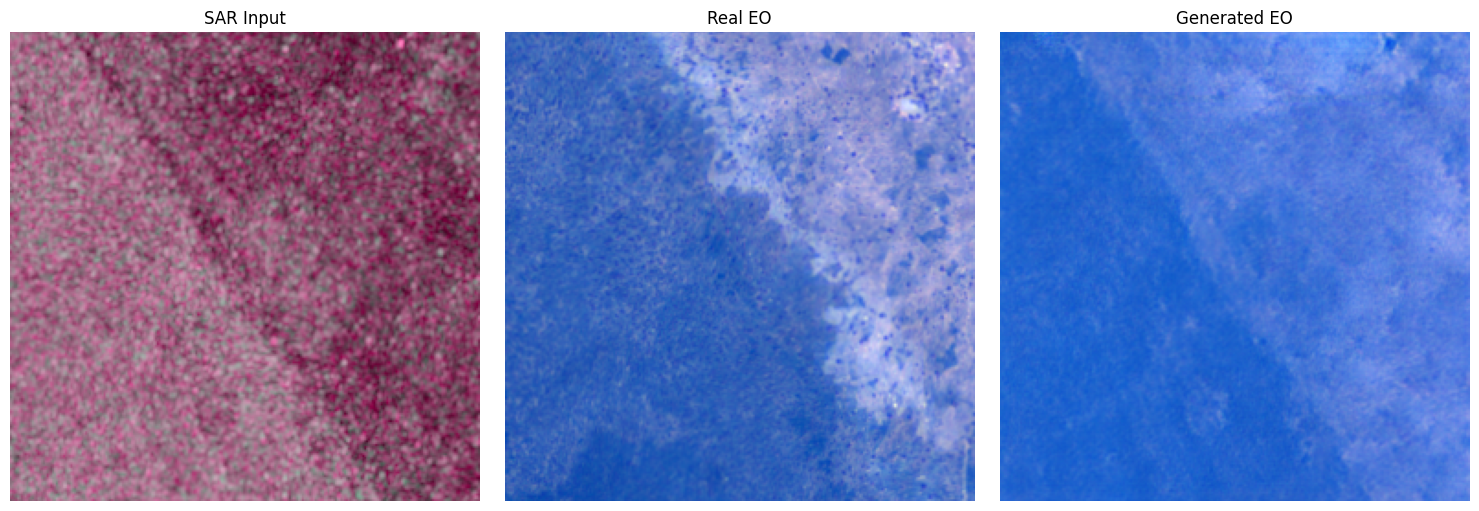

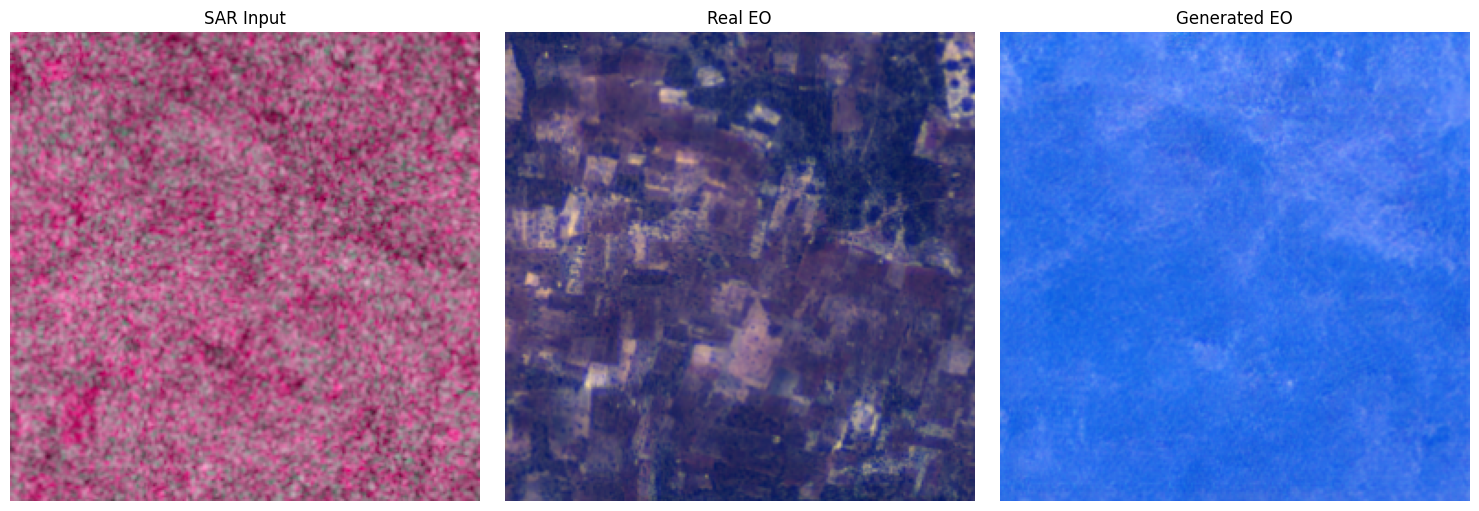

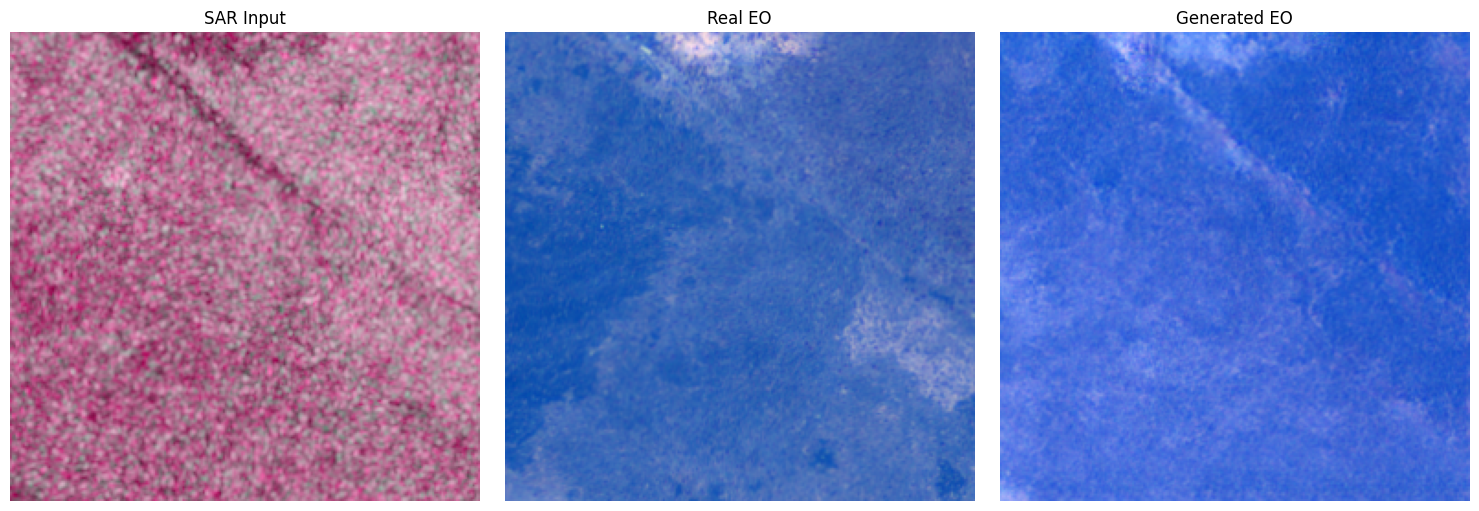

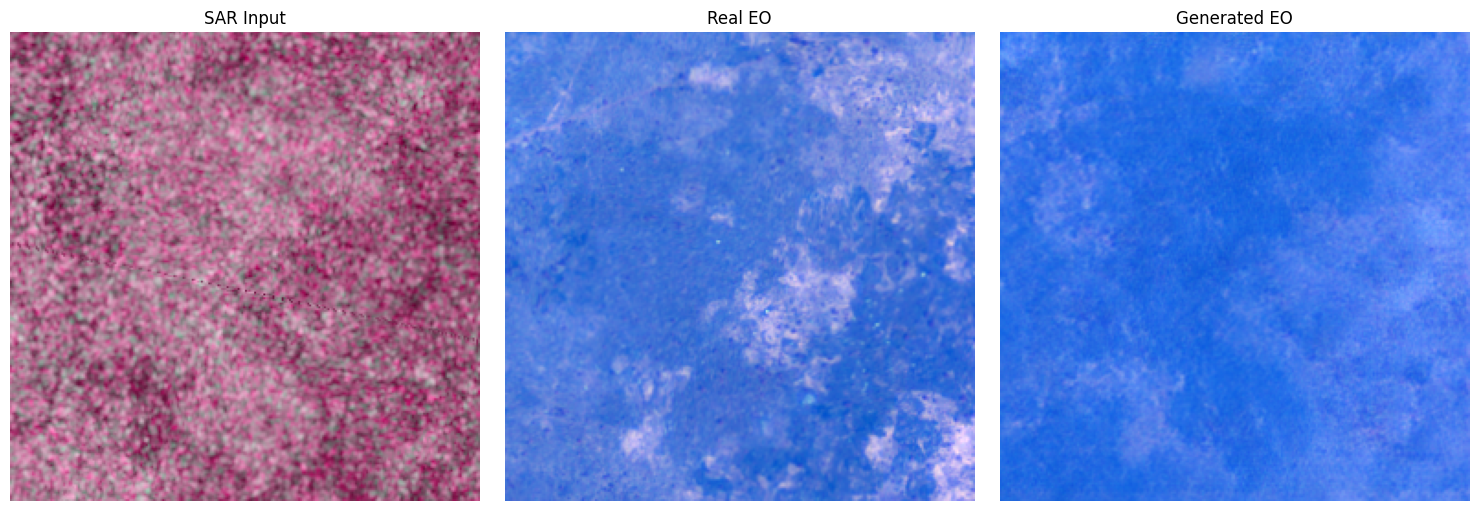

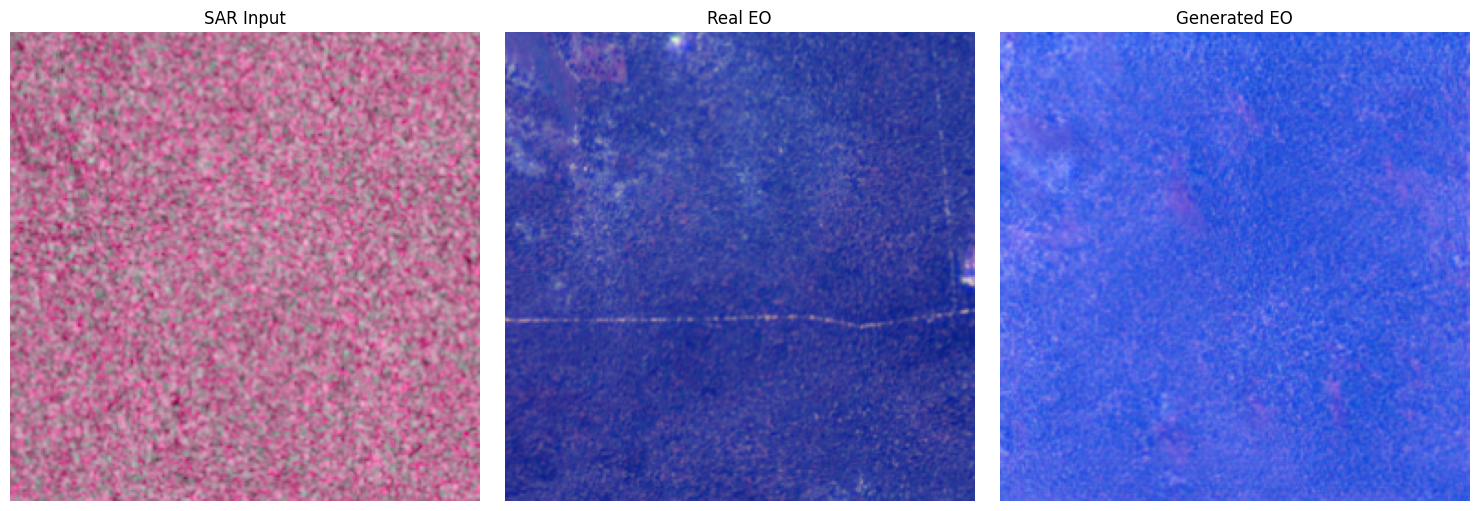

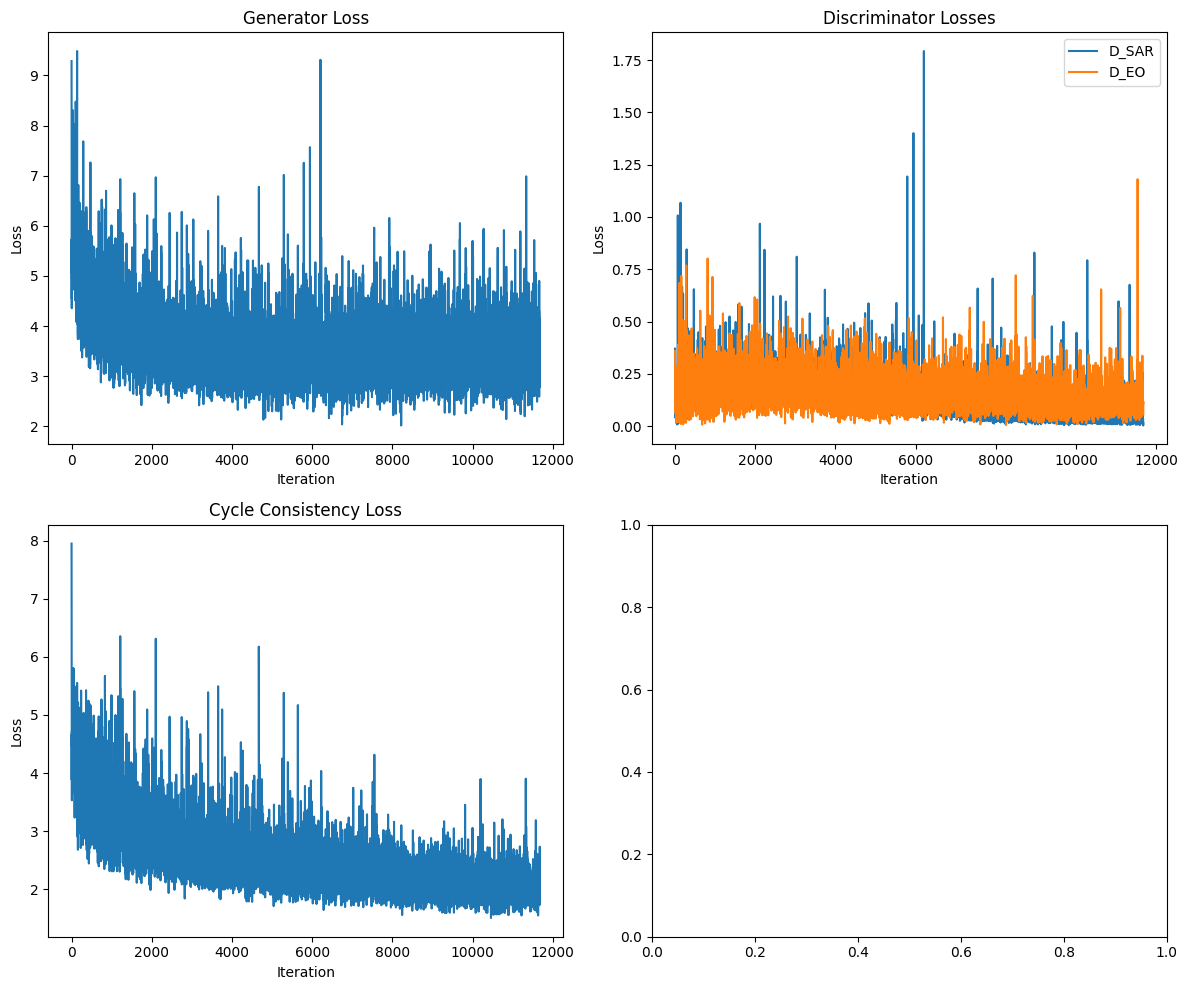

Models saved as /kaggle/working/final_model_rgb.pth.pth

TRAINING COMPLETE - SUMMARY OF RESULTS

RGB Configuration:
  SSIM: 0.4962 ± 0.0821
  PSNR: 17.9358 ± 3.9486


In [38]:
# ===== EXECUTION SECTION =====

# Configuration
DATA_DIR = "/kaggle/input/sen12ms-subset/sen12ms-subset"
SAR_DIR = os.path.join(DATA_DIR, "ROIs2017_winter_s1")
EO_DIR = os.path.join(DATA_DIR, "ROIs2017_winter_s2")

# Check if data directories exist
if not os.path.exists(SAR_DIR) or not os.path.exists(EO_DIR):
    print("Data directories not found. Please update the paths:")
    print(f"SAR_DIR: {SAR_DIR}")
    print(f"EO_DIR: {EO_DIR}")
    print("\nPlease download the data from: https://dataserv.ub.tum.de/s/m1474000")
else:
    # Train models for all three configurations
    # configs = ['rgb', 'nir_swir_red_edge', 'rgb_nir']
    configs = ['rgb']
    results = {}
    
    for config in configs:
        trainer, metrics = train_cyclegan_config(
            SAR_DIR, EO_DIR, 
            band_config=config, 
            num_epochs=40,  # Adjust based on your computational resources
            batch_size=4    # Adjust based on your GPU memory
        )
        results[config] = {'trainer': trainer, 'metrics': metrics}
    
    # Summary of results
    print("\n" + "="*50)
    print("TRAINING COMPLETE - SUMMARY OF RESULTS")
    print("="*50)
    
    for config, result in results.items():
        metrics = result['metrics']
        print(f"\n{config.upper()} Configuration:")
        print(f"  SSIM: {metrics['avg_ssim']:.4f} ± {metrics['ssim_std']:.4f}")
        print(f"  PSNR: {metrics['avg_psnr']:.4f} ± {metrics['psnr_std']:.4f}")

In [39]:
# ===== ADDITIONAL UTILITIES =====

def create_requirements_txt():
    """Create requirements.txt file for the project"""
    requirements = """
torch>=1.9.0
torchvision>=0.10.0
numpy>=1.21.0
matplotlib>=3.3.0
scikit-image>=0.18.0
opencv-python>=4.5.0
Pillow>=8.0.0
tqdm>=4.60.0
"""
    with open('requirements.txt', 'w') as f:
        f.write(requirements.strip())
    print("requirements.txt created successfully!")

def create_project_structure():
    """Create the required project directory structure"""
    dirs = [
        'generated_samples',
        'generated_samples/rgb',
        'generated_samples/nir_swir_red_edge', 
        'generated_samples/rgb_nir',
        'checkpoints'
    ]
    
    for dir_name in dirs:
        os.makedirs(dir_name, exist_ok=True)
    
    print("Project directory structure created!")

# Create project structure and requirements
create_project_structure()
create_requirements_txt()

print("\n" + "="*60)
print("SAR TO EO IMAGE TRANSLATION CYCLEGAN - READY TO RUN")
print("="*60)
print("\nNext steps:")
print("1. Download the Sen12MS dataset from: https://dataserv.ub.tum.de/s/m1474000")
print("2. Extract ROIs2017_winter_s1.tar.gz and ROIs2017_winter_s2.tar.gz")
print("3. Update the DATA_DIR path in the configuration section")
print("4. Run the training pipeline")
print("\nThe notebook will train CycleGAN models for all three band configurations:")
print("- SAR → EO (RGB: B4, B3, B2)")
print("- SAR → EO (NIR, SWIR, Red Edge: B8, B11, B5)")  
print("- SAR → EO (RGB + NIR: B4, B3, B2, B8)")

Project directory structure created!
requirements.txt created successfully!

SAR TO EO IMAGE TRANSLATION CYCLEGAN - READY TO RUN

Next steps:
1. Download the Sen12MS dataset from: https://dataserv.ub.tum.de/s/m1474000
2. Extract ROIs2017_winter_s1.tar.gz and ROIs2017_winter_s2.tar.gz
3. Update the DATA_DIR path in the configuration section
4. Run the training pipeline

The notebook will train CycleGAN models for all three band configurations:
- SAR → EO (RGB: B4, B3, B2)
- SAR → EO (NIR, SWIR, Red Edge: B8, B11, B5)
- SAR → EO (RGB + NIR: B4, B3, B2, B8)
